# Demographics and SAT Scores

Higher education is something all people should want and be able to achieve, regardless of whether it is motivated by professional or personal growth. However, many institutes of higher education use, among other things, the [Scholastic Aptitude Test](https://blog.prepscholar.com/what-is-the-sat-a-complete-explanation-of-the-test), or SAT, score to determine eligibility. In theory this allows schools to be more selective of the students that it admits on basis of probability of academic success. Practically, however, SAT scores may be influenced by external factors that are unrelated to a student's intelligence or academic capacity. 

New York City has published SAT scores and demographic data across its schools. As New York City is a very diverse area, that data could show some indication of demographic inequity with regards to SAT scores. 

# Contents
 - 0. [Data](#Data): A breakdown of the data being used in this project. 
 - 1. [Mission](#Mission): An explanation of the intended accomplishments.
 - 2. [Getting Started](#get_start): Reading in the data, cleaning, and amalgamating it.
 - 3. [Scorrelationes](#com_cor): The way the SAT score correlates with other factors. 
 - 4. [Population vs Score](#population): What happens the more students a school has. 
 - 5. [English as a Second Language](#esl_sat): The effect of having a larger number of ESL classes.
 - 6. [Safety Stance](#safety_dance): Closer examination of how the feeling of safety correlates to SAT scores. 
 - 7. [Race and Score](#racial_inequity): How race correlates to score.
 - 8. [SATs and Gender](#fe_male): Males' and Females' Performance.
 - 9. [AP Testing vs Score](#ap_percent): How AP testing affects SAT scores.
 - 10. [The Inequity of Poverty](#poverty): Poverty and its effect on students' success.
 - 11. [Conclusion](#isitover): Conclusion.
 - 12. [Acknowledgements](#ack)

<a id='Data'></a>
# Data: What are we working with? 

This data has all been provided by New York City about all of their schools' demographics and SAT scores. 
- [SAT scores by school](https://data.cityofnewyork.us/Education/SAT-Results/f9bf-2cp4): SAT scores for each high school in New York City
- [School attendance](https://data.cityofnewyork.us/Education/School-Attendance-and-Enrollment-Statistics-by-Dis/7z8d-msnt): Attendance information for each school in New York City
- [Class size](https://data.cityofnewyork.us/Education/2010-2011-Class-Size-School-level-detail/urz7-pzb3): Information on class size for each school
- [AP test results](https://data.cityofnewyork.us/Education/AP-College-Board-2010-School-Level-Results/itfs-ms3e): Advanced Placement (AP) exam results for each high school (passing an optional AP exam in a particular subject can earn a student college credit in that subject)
- [Graduation outcomes](https://data.cityofnewyork.us/Education/Graduation-Outcomes-Classes-Of-2005-2010-School-Le/vh2h-md7a): The percentage of students who graduated, and other outcome information
- [Demographics](https://data.cityofnewyork.us/Education/School-Demographics-and-Accountability-Snapshot-20/ihfw-zy9j): Demographic information for each school
- [School survey](https://data.cityofnewyork.us/Education/NYC-School-Survey-2011/mnz3-dyi8): Surveys of parents, teachers, and students at each school

<a id='Mission'></a>
# Mission: Demographic Correlation
This project will revolve around examining the relationship between demographics and SAT scores and whether the SAT scores are an equitable means of aptitude assessment. There are a few different distinct questions that we will seek to answer:

- Are there common traits to low-scoring schools that are lesser or even nonexistent in higher-scoring schools?  
- Does race have influence on SAT scores? 
- How do the schools influence their students' SAT scores?
- How does gender influence SAT scores? 




<a id='get_start'></a>
# Getting Started: Read, Clean, Combine

- Links to and descriptions of the data files are all found in the [Data] section above. 

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import re
import matplotlib.pyplot as plt
data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]
data = {}
for v in range(0,6):
    file = data_files[v]
    title = file[:-4]
    data[title] = pd.read_csv('schools/'+file)

In [3]:
%matplotlib inline

In [4]:
all_survey = pd.read_csv("schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pd.read_csv("schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pd.concat([all_survey, d75_survey], axis=0)

survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_11", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]
data["survey"] = survey

- Once they're all in, the first step is ensuring the consistency of the `DBN` columns in all of the dataframes so each school can be combined across all of the data. A DBN is a [District Borough Number](https://teachnyc.zendesk.com/hc/en-us/articles/360053601831-What-is-a-DBN-District-Borough-Number) which is a unique identifier for every school in the area. 

In [5]:
data['hs_directory']['DBN'] = data['hs_directory']['dbn']
hs_directory = data['hs_directory'].copy()

In [6]:
class_size = data['class_size'].copy()
class_size['padded_csd'] = class_size['CSD'].apply(lambda x: str(x).zfill(2) if len(str(x)) == 1 else None) 
class_size['DBN'] = class_size['CSD'].astype(str) + class_size['SCHOOL CODE']

- The `sat_results` dataset has some SAT score columns that must be converted to numeric values, and we added a fourth column that is the total SAT score (`sat_score`).

In [7]:
sat_results = data['sat_results'].copy()
score_col = ['SAT Critical Reading Avg. Score', 'SAT Math Avg. Score',
       'SAT Writing Avg. Score']
sat_results[score_col]
score_df = sat_results[score_col]
more_df = score_df.copy()
for col in score_df.columns:
    more_df[col] = pd.to_numeric(score_df[col], errors='coerce')
set_one = more_df['SAT Critical Reading Avg. Score'] + more_df['SAT Math Avg. Score'] + more_df['SAT Writing Avg. Score']
sat_results[score_col] = more_df
sat_results['sat_score']=set_one

In [8]:
data['sat_results']=sat_results

- The `hs_directory` dataset has geographical coordinates embedded in one column, those must be extracted and converted into numeric values. 

In [9]:
def find_lat(loc):
    coords = re.findall("\(.+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_long(loc):
    coords = re.findall("\(.+\)", loc)
    long = coords[0].split(",")[1].replace(")", "")
    return long



In [10]:
hs_lat = hs_directory['Location 1'].apply(find_lat)
hs_long = hs_directory['Location 1'].apply(find_long)
hs_lat = pd.to_numeric(hs_lat)
hs_long = pd.to_numeric(hs_long)
hs_directory['lat'] = hs_lat
hs_directory['lon'] = hs_long

In [11]:
hs_directory['borough'].unique()

array(['Queens', 'Brooklyn', 'Bronx', 'Manhattan', 'Staten Island'],
      dtype=object)

In [12]:
data['hs_directory'] = hs_directory

- Clean and Condensing data: There is a lot of extraneous data that we can trim out so we can have more relevant data.     
    - The `class_size` dataset will be purged of unnecessary data by removing non `GEN ED` classes and using only grades 9-12. 
    - The `demographics` dataset will have only one schoolyear's worth of data (2011-2012). 
    - The `graduation` dataset is also reduced by year and only classes that are complete. 

In [13]:
cs_clean = class_size.copy()
cs_clean = class_size[class_size['GRADE ']=='09-12']
cs_clean = cs_clean[cs_clean['PROGRAM TYPE'] == 'GEN ED']
class_size = cs_clean
groupedup = class_size.groupby('DBN')
groupednew = groupedup.agg(np.mean)
old_class = class_size.copy()
class_size = groupednew
class_size.reset_index(inplace=True)
data['class_size'] = class_size

In [14]:
demos = data['demographics'].copy()
ndemos = demos[demos['schoolyear'] == 20112012]
data['demographics'] = ndemos

In [15]:
gradsy = data['graduation']

gradsy2 = gradsy[gradsy['Cohort'] == '2006']
gradsy1 = gradsy2[gradsy2['Demographic'] == 'Total Cohort']
data['graduation'] = gradsy1

- The AP scores found in `ap_2010` need to be converted into numeric values (from their string forms) so that they can be effectively plotted and manipulated. 

In [16]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']
ap_2010 = data['ap_2010'].copy()
for col in cols:
    ap_2010[col] = pd.to_numeric(ap_2010[col], errors="coerce")
data['ap_2010'] = ap_2010

- Merging the Data: Now that all of the individual datasets are relatively consistent in their data types, the process of merging them can begin. The first dataset will be `data['sat_results']` which will be merged left with `ap_2010` and `graduation`. Next it will merge `inner` with `class_size`, `demographics`, `survey`, and `hs_directory`. Finally it will have any `NaN` values filled with averages of their respective columns, and anything left as `NaN` after that will simply be zeroed out. 

In [17]:
data['sat_results']

,DBN,SCHOOL NAME,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,sat_score
0,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL STUDIES,29,355.0,404.0,363.0,1122.0
1,01M448,UNIVERSITY NEIGHBORHOOD HIGH SCHOOL,91,383.0,423.0,366.0,1172.0
2,01M450,EAST SIDE COMMUNITY SCHOOL,70,377.0,402.0,370.0,1149.0
3,01M458,FORSYTH SATELLITE ACADEMY,7,414.0,401.0,359.0,1174.0
4,01M509,MARTA VALLE HIGH SCHOOL,44,390.0,433.0,384.0,1207.0
...,...,...,...,...,...,...,...
473,75X012,P.S. X012 LEWIS AND CLARK SCHOOL,s,NaN,NaN,NaN,NaN
474,75X754,J. M. RAPPORT SCHOOL CAREER DEVELOPMENT,s,NaN,NaN,NaN,NaN
475,79M645,SCHOOL FOR COOPERATIVE TECHNICAL EDUCATION,s,NaN,NaN,NaN,NaN
476,79Q950,GED PLUS s CITYWIDE,8,496.0,400.0,426.0,1322.0


In [18]:
combined = data['sat_results'].copy() 
combined = combined.merge(data['ap_2010'], how='left', on='DBN')
combined = combined.merge(data['graduation'], how='left', on='DBN')
to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

In [19]:
combined['borough'].unique()

array(['Bronx', 'Brooklyn', 'Queens', 'Staten Island'], dtype=object)

In [20]:
combined.shape

(229, 165)

- Adding a district column: Now that all of the data is in one place (`combined`), the column `school_district` will be made, which allows checking across school districts for easier visual representation. 

In [21]:
def get_chars(string):
    return string[0:2]
combined['school_dist'] = combined['DBN'].apply(get_chars)

<a id='com_cor'></a>
# Scorrelations

With the data combined in a single dataframe, it will be much easier to analyze the relationships between the SAT score and other factors. The correlation dataframe is a good place to start, to visually assess the initial points of interest. 

In [22]:
correlations = combined.corr()
display(correlations)

,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,sat_score,AP Test Takers,Total Exams Taken,Number of Exams with scores 3 4 or 5,Total Cohort,Total Grads - % of cohort,Total Regents - % of cohort,...,priority08,priority09,priority10,Community Board,Council District,Census Tract,BIN,BBL,lat,lon
SAT Critical Reading Avg. Score,1.000000,0.925619,0.983598,0.986212,0.489812,0.485344,0.440857,0.297362,0.558773,0.636729,...,NaN,NaN,NaN,-0.064078,0.018959,0.027571,0.287350,0.282722,-0.086015,-0.050917
SAT Math Avg. Score,0.925619,1.000000,0.930644,0.971654,0.572992,0.562082,0.486219,0.416395,0.504615,0.608237,...,NaN,NaN,NaN,-0.077003,0.009473,0.022759,0.318928,0.318128,-0.089011,-0.047901
SAT Writing Avg. Score,0.983598,0.930644,1.000000,0.988152,0.515327,0.510641,0.463331,0.307824,0.558711,0.643102,...,NaN,NaN,NaN,-0.060105,0.021110,0.011302,0.278084,0.275082,-0.078872,-0.066267
sat_score,0.986212,0.971654,0.988152,1.000000,0.537677,0.530710,0.473041,0.349692,0.549498,0.640378,...,NaN,NaN,NaN,-0.068664,0.016574,0.020953,0.301147,0.298363,-0.086350,-0.055850
AP Test Takers,0.489812,0.572992,0.515327,0.537677,1.000000,0.992036,0.889942,0.585447,0.248897,0.324427,...,NaN,NaN,NaN,-0.003836,0.058679,0.055853,0.136636,0.136213,-0.070155,-0.058646
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Census Tract,0.027571,0.022759,0.011302,0.020953,0.055853,0.058137,0.034754,0.032213,0.069581,0.076098,...,NaN,NaN,NaN,0.189896,-0.047704,1.000000,0.189175,0.198732,-0.101114,0.289334
BIN,0.287350,0.318928,0.278084,0.301147,0.136636,0.106267,0.007781,0.297058,0.165203,0.199014,...,NaN,NaN,NaN,-0.096681,0.458049,0.189175,1.000000,0.991144,-0.624479,-0.020236
BBL,0.282722,0.318128,0.275082,0.298363,0.136213,0.105470,0.008862,0.303529,0.146783,0.182972,...,NaN,NaN,NaN,-0.113257,0.456254,0.198732,0.991144,1.000000,-0.617896,-0.035141
lat,-0.086015,-0.089011,-0.078872,-0.086350,-0.070155,-0.055883,-0.011268,-0.145147,-0.022713,-0.042260,...,NaN,NaN,NaN,-0.172793,-0.937756,-0.101114,-0.624479,-0.617896,1.000000,0.374238


- Remove DBN since it's a unique identifier, not a useful numerical value for correlation.

In [23]:
survey_fields.remove("DBN")

The Survey contains a whole lot of data, organized into different categories, many of which are listed below:

| Field Name | Field Description |
| --- | --- |
| dbn | School identification code (district borough number) |
| sch_type | School type (Elementary, Middle, High, etc) |
| location | School name |
| enrollment | Enrollment size |
| borough | Borough |
| principal | Principal name |
| studentsurvey | Only students in grades 6-12 partipate in the student survey. This field indicates whether or not this school serves any students in grades 6-12. |
| rr_s | Student Response Rate |
| rr_t | Teacher Response Rate |
| rr_p | Parent Response Rate |
| N_s | Number of student respondents |
| N_t | Number of teacher respondents |
| N_p | Number of parent respondents |
| nr_s | Number of eligible students |
| nr_t | Number of eligible teachers |
| nr_p | Number of eligible parents |
| saf_p_10 | Safety and Respect score based on parent responses |
| com_p_10 | Communication score based on parent responses |
| eng_p_10 | Engagement score based on parent responses |
| aca_p_10 | Academic expectations score based on parent responses |
| saf_t_10 | Safety and Respect score based on teacher responses |
| com_t_10 | Communication score based on teacher responses |
| eng_t_10 | Engagement score based on teacher responses |
| aca_t_10 | Academic expectations score based on teacher responses |
| saf_s_10 | Safety and Respect score based on student responses |
| com_s_10 | Communication score based on student responses |
| eng_s_10 | Engagement score based on student responses |
| aca_s_10 | Academic expectations score based on student responses |
| saf_tot_10 | Safety and Respect total score |
| com_tot_10 | Communication total score |
| eng_tot_10 | Engagement total score |
| aca_tot_10 | Academic Expectations total score |

All of that data is kind of overwhelming at first glance, so it will be easier to break it down and visually remove irrelevant data. A bar graph showing the correlations between the full SAT score and each survey field will help quickly see where to start.

In [24]:
correlations.columns

Index(['SAT Critical Reading Avg. Score', 'SAT Math Avg. Score',
       'SAT Writing Avg. Score', 'sat_score', 'AP Test Takers ',
       'Total Exams Taken', 'Number of Exams with scores 3 4 or 5',
       'Total Cohort', 'Total Grads - % of cohort',
       'Total Regents - % of cohort', 'Total Regents - % of grads',
       'Advanced Regents - % of cohort', 'Advanced Regents - % of grads',
       'Regents w/o Advanced - % of cohort',
       'Regents w/o Advanced - % of grads', 'Local - % of cohort',
       'Local - % of grads', 'Still Enrolled - % of cohort',
       'Dropped Out - % of cohort', 'CSD', 'NUMBER OF STUDENTS / SEATS FILLED',
       'NUMBER OF SECTIONS', 'AVERAGE CLASS SIZE', 'SIZE OF SMALLEST CLASS',
       'SIZE OF LARGEST CLASS', 'SCHOOLWIDE PUPIL-TEACHER RATIO', 'schoolyear',
       'fl_percent', 'frl_percent', 'total_enrollment', 'ell_num',
       'ell_percent', 'sped_num', 'sped_percent', 'asian_num', 'asian_per',
       'black_num', 'black_per', 'hispanic_num', 'hispa

The significant correlations will be any x for which |x| > 0.3. We can model a bar graph around that to see where the most important correlations lie. 

In [25]:
correlations = correlations["sat_score"]

In [26]:
sig_corrs = correlations[(correlations > 0.30) | (correlations < -0.30)]
sig_corrs.sort_values()

frl_percent                            -0.709116
Regents w/o Advanced - % of grads      -0.515787
Still Enrolled - % of cohort           -0.483484
Local - % of grads                     -0.482718
Local - % of cohort                    -0.459097
ell_percent                            -0.427995
sped_percent                           -0.406189
Dropped Out - % of cohort              -0.396559
hispanic_per                           -0.346607
BIN                                     0.301147
N_t                                     0.303398
aca_s_11                                0.305224
saf_s_11                                0.316118
saf_tot_11                              0.320613
SIZE OF LARGEST CLASS                   0.326461
saf_t_11                                0.327639
Total Cohort                            0.349692
male_num                                0.357113
NUMBER OF SECTIONS                      0.365178
AVERAGE CLASS SIZE                      0.382213
total_enrollment    

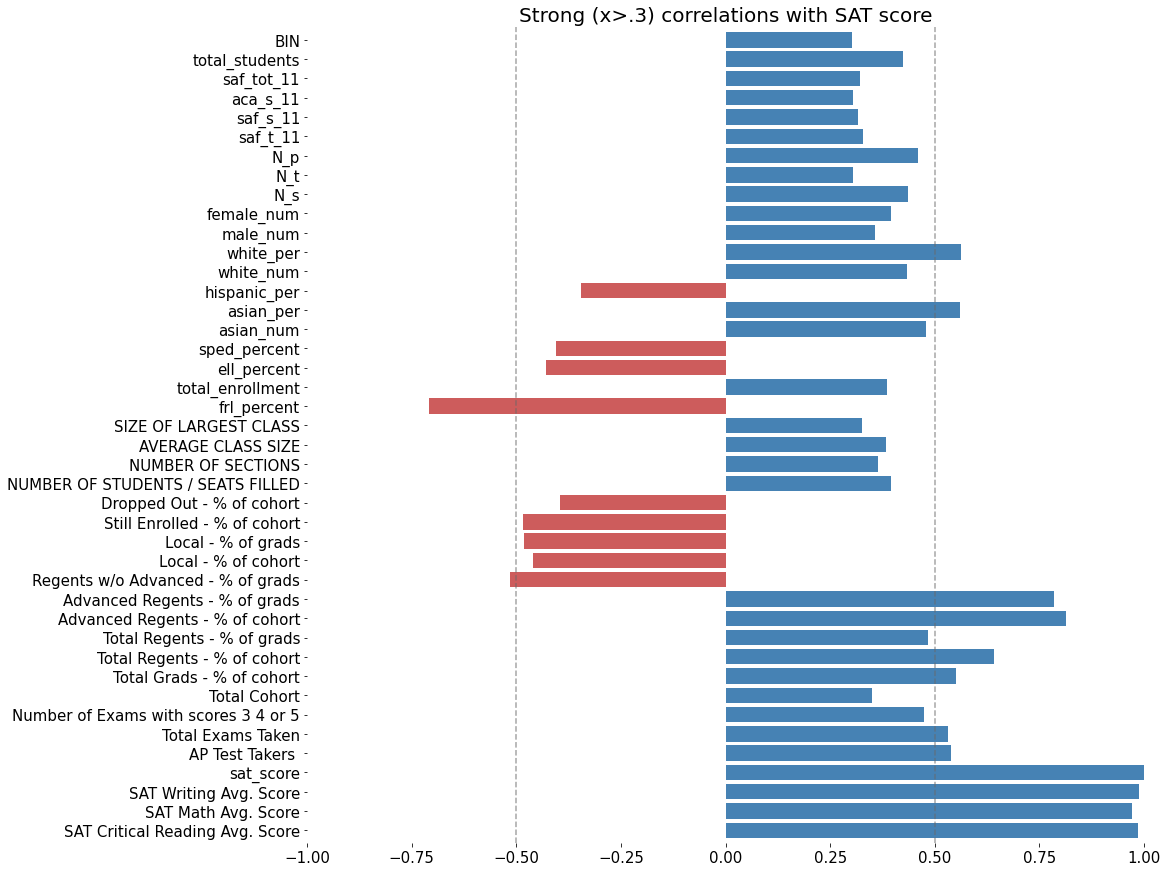

In [27]:
negative = sig_corrs < 0
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(1,1,1)
ax = sig_corrs.plot.barh(fontsize=15,
                                  width=0.8,
                                  color=negative.map({True: "indianred", False: "steelblue"})
                                 )
ax.set_title("Strong (x>.3) correlations with SAT score", size=20)
ax.set_xlim(-1,1)
ax.axvline(0.5, color="dimgray", alpha=0.6, linestyle="--")
ax.axvline(-0.5, color="dimgray", alpha=0.6, linestyle="--")
ax.spines["right"].set_visible(False)    
ax.spines["left"].set_visible(False)
ax.spines["top"].set_visible(False)    
ax.spines["bottom"].set_visible(False)
plt.show()

Now we can start making initial observations on the data itself to see where the points of interest will be:

- `total_enrollment` has a strong positive correlation with sat_score. This is surprising because we'd expect smaller schools where students receive more attention to have higher scores. However, it looks like the opposite is true -- larger schools tend to do better on the SAT.
- Other columns that are proxies for enrollment correlate similarly. These include `total_students`, `N_s`, `N_p`, `N_t`, `AP Test Takers`, `Total Exams Taken`, and `NUMBER OF SECTIONS`.
- Both the percentage of females (`female_per`) and number of females (`female_num`) at a school correlate positively with SAT score, whereas the percentage of males (`male_per`) and the number of males (`male_num`) correlate negatively. This could indicate that women do better on the SAT than men.
- Teacher and student ratings of school safety (`saf_t_11`, and `saf_s_11`) correlate with `sat_score`.
- Student ratings of school academic standards (`aca_s_11`) correlate with `sat_score`, but this does not hold for ratings from teachers and parents (`aca_p_11` and `aca_t_11`).
- There is significant racial inequality in SAT scores (`white_per`, `asian_per`, `black_per`, `hispanic_per`).
- The percentage of English language learners at the school (`ell_percent`, `frl_percent`) has a strong negative correlation with SAT scores.


<a id='population'></a>
# Population vs Score

Because enrollment seems to have such a strong correlation, let's make a scatterplot of `total_enrollment` vs `sat_score`. Each point in the scatterplot will represent a high school, so we'll be able to see if there are any interesting patterns.

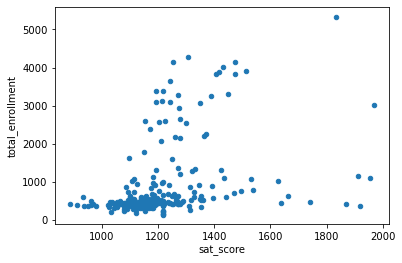

In [28]:
combined.plot.scatter(x='sat_score', y='total_enrollment')

Upon examining the scatter plot we can see that the correlation seems to come from the fact that the schools with fewer students are performing poorly, and not necessarily that the schools with more students are performing particularly well. This could be due to a variety of factors, but the first step is taking a closer look at the most interesting part of the graph above: the clump of schools with lower than 1000 students which all performed relatively poorly (i.e., scored less than 1000 on average). 

Another important factor to bear in mind is that lower enrollment means smaller schools, and smaller schools tend to have [lessened capacity for college preparation](https://www.gao.gov/products/GAO-19-8).

In [29]:
low_enrollment = combined[combined['total_enrollment'] < 1000]
low_enrollment = low_enrollment[low_enrollment['sat_score']<1000]

In [30]:
schools_names = low_enrollment['SCHOOL NAME'].unique()
print(schools_names)

['KINGSBRIDGE INTERNATIONAL HIGH SCHOOL'
 'INTERNATIONAL SCHOOL FOR LIBERAL ARTS'
 'PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE'
 'HIGH SCHOOL OF WORLD CULTURES' 'BROOKLYN INTERNATIONAL HIGH SCHOOL'
 'INTERNATIONAL HIGH SCHOOL AT PROSPECT HEIGHTS'
 'IT TAKES A VILLAGE ACADEMY' 'MULTICULTURAL HIGH SCHOOL'
 'PAN AMERICAN INTERNATIONAL HIGH SCHOOL']


Immediately, it has become apparent that all of these schools are going to have a significant number of English as Second Language (ESL) students. To see how that affects SAT score independantly we can check the correlation between `sat_score` and `ell_percent` above (strong negative correlation) and check the scatter plot for all schools. 

<a id='esl_sat'></a>
# English as a Second Language
 The barrier of entry to academia in foreign countries vary, regardless of linguistic prowess, but there appears to be a distinct difficulty of schools with higher percentages of ESL students to place higher in average SAT scores.

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


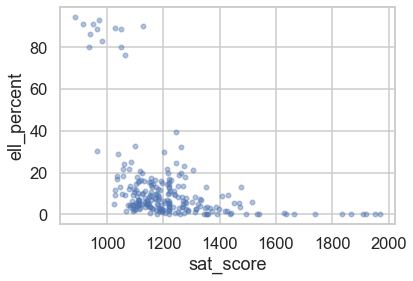

In [77]:
combined.plot.scatter(x='sat_score', y='ell_percent', alpha=.4)

While the divide is clear, schools who have a higher percentage of ESL students tend to have lower SAT scores on average, the reasoning behind that is not. Perhaps the SAT is unfavorable to those whose English language skills are not very strong (reasonable, since a large portion (two-thirds) of the SAT is based on English comprehension). Perhaps also those schools with higher-than-average ESL students also have lower budgets and therefore less financial freedom to help educate their students in preparation for standardized testing, due to their already greater fiscal strain of across-the-board ESL classes.

<a id = 'safety_dance'></a>
# The Safety Stance
Another clear influence on SAT score was the perceived safety of the school environment by both the students and teachers.

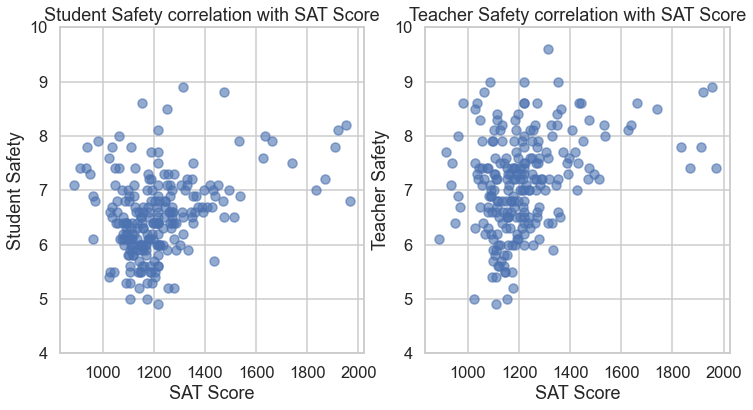

In [80]:
fig = plt.figure(figsize=(12,6))
ax5 = fig.add_subplot(121)
ax6 = fig.add_subplot(122)

ax5.scatter(combined['sat_score'], combined['saf_s_11'], alpha=.6)
ax5.set_title('Student Safety correlation with SAT Score')
ax5.set_xlabel('SAT Score')
ax5.set_ylabel('Student Safety')
ax5.set_ylim(4,10)

ax6.scatter(combined['sat_score'], combined['saf_t_11'], alpha=.6)
ax6.set_title('Teacher Safety correlation with SAT Score')
ax6.set_xlabel('SAT Score')
ax6.set_ylabel('Teacher Safety')
ax6.set_ylim(4,10)
plt.show()

These graphs look pretty similar, so we can take a look at how they combine to affect SAT scores together (maybe students' perception of safety has a greater influence on the scores or the opposite?). 

Text(0, 0.5, 'Teacher Safety')

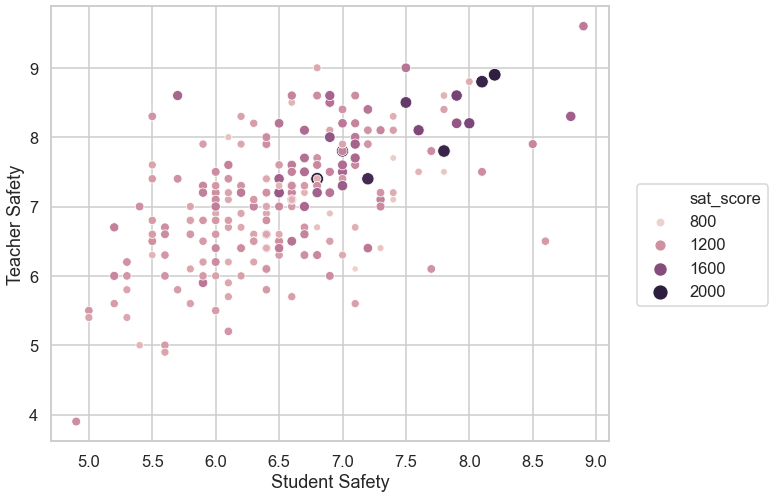

In [33]:
sns.set(style='whitegrid', context='talk')
plt.figure(figsize=(10,8))
sns.scatterplot(x='saf_s_11', y='saf_t_11', size='sat_score', hue='sat_score', data=combined)
plt.legend(loc='upper right', bbox_to_anchor=(1.3, .61));
plt.xlabel('Student Safety')
plt.ylabel('Teacher Safety')

It seems like the safety of both students and teachers correlate similarly to SAT score, and where both are good, the scores are better, but there are some obvious exceptions (the point with highest student *and* teacher safety scored only within the 1200 range). 

In [34]:
cols_pl = ['sat_score', 'saf_t_11', 'saf_s_11', 'borough']
bor_saf = combined[cols_pl]
bor_com = bor_saf.groupby('borough').agg('mean')

In [35]:
combined["borough_id"] = combined["DBN"].apply(lambda dbn: dbn[2])
borough_avg = combined.groupby("borough_id").agg('mean')
print('\033[1m' + "Safety Scores across boroughs in ascending order of Safety Score" + '\033[0m')
borough_avg['saf_s_11'].sort_values()

Safety Scores across boroughs in ascending order of Safety Score


borough_id
K    6.370755
R    6.530000
X    6.589796
Q    6.721875
Name: saf_s_11, dtype: float64

The safety averages for all of the boroughs seem to be roughly the same, with some more 'extreme' outliers but ultimately, on average, the borough have similar safety ratings for their schools. 

In [106]:
safe_students = combined[combined['saf_s_11']>7.5]
safe_teachers = combined[combined['saf_t_11']>7.5]
unsafe_st = combined[combined['saf_s_11']<5.5]
unsafe_t = combined[combined['saf_t_11']<5.5]

<a id='race_sat'></a>
# SAT scores and Race
There are four different categories of race that were surveyed, `white_per`, `asian_per`, `black_per`, and `hispanic_per`. 

In [36]:
races_score = ['white_per', 'asian_per', 'black_per', 'hispanic_per', 'sat_score']
races = ['white_per', 'asian_per', 'black_per', 'hispanic_per']

In [37]:
race_cor = combined[races_score].corr()

In [38]:
racor = race_cor['sat_score']
racor = racor[races] 

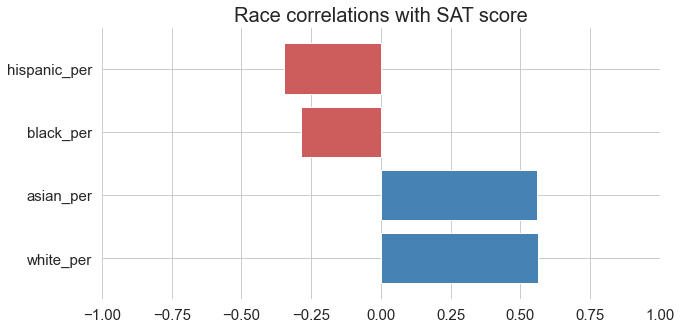

In [39]:
negative = racor < 0
sns.set_context('notebook')
fig = plt.figure(figsize=(10,5))
ax = racor.plot.barh(fontsize=15,
                                  width=0.8,
                                  color=negative.map({True: "indianred", False: "steelblue"})
                                 )
ax.set_title("Race correlations with SAT score", size=20)
ax.set_xlim(-1,1)
ax.spines["right"].set_visible(False)    
ax.spines["left"].set_visible(False)
ax.spines["top"].set_visible(False)    
ax.spines["bottom"].set_visible(False)
plt.show()

While the Asian percentage and the White percentage seem to have a positive correlation with SAT scores, hispanic and black percentages have a negative correlation. This is a major red flag as this could indicate that the SATs are systemically "unfair".

In [94]:
his_students = combined[combined['hispanic_per']>90]
aa_students = combined[combined['black_per']>90]

In [130]:
his_students['saf_t_11']

7      7.1
42     6.7
119    6.1
152    6.4
Name: saf_t_11, dtype: float64

In [131]:
aa_students['saf_s_11']

89     6.6
101    8.6
102    7.3
103    8.0
107    7.5
197    6.0
Name: saf_t_11, dtype: float64

Schools with higher percentages of black students also have some of the lowest safety ratings among students (seen above), which has been seen to negatively affect SAT scores. Most of the schools also presented with student lunch financial assistance rates of over 45%. 

<a id="fe_male"></a>
# SATs and Gender
The only explicit data regarding gender within the surveys is male and female so that is what will be analyzed. Below are four scatters that will show the relationship that SAT scores have with male and female students. 


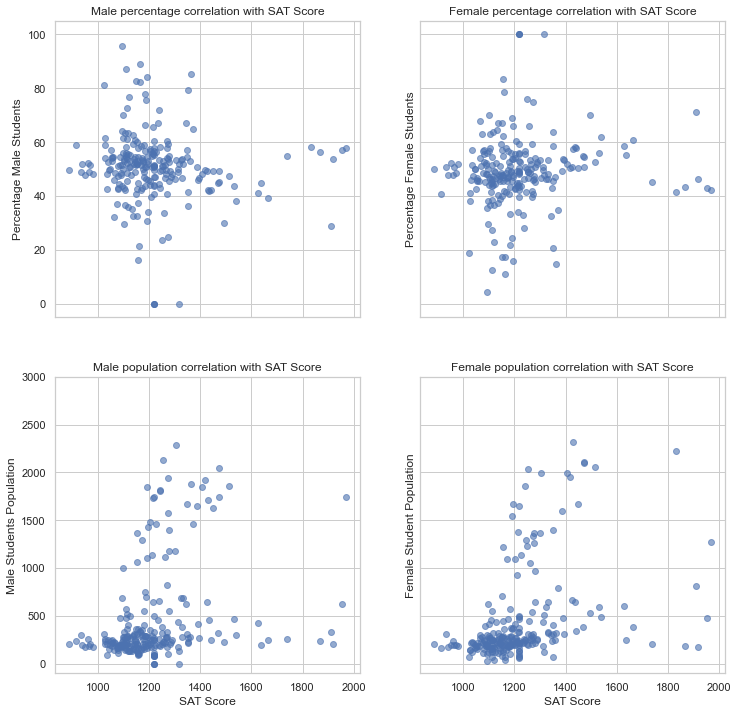

In [54]:
fig = plt.figure(figsize=(12,12))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)

ax1.scatter(combined['sat_score'], combined['male_per'],alpha=0.6)
ax1.set_title('Male percentage correlation with SAT Score')
ax1.set_ylabel('Percentage Male Students')
ax1.tick_params(labelbottom=False)
ax1.set_ylim(-5,105)

ax2.scatter(combined['sat_score'], combined['female_per'],alpha=0.6)
ax2.set_title('Female percentage correlation with SAT Score')
ax2.tick_params(labelbottom=False, labelleft=False)
ax2.set_ylabel('Percentage Female Students')
ax2.set_ylim(-5,105)

ax3.scatter(combined['sat_score'], combined['male_num'],alpha=0.6)
ax3.set_title('Male population correlation with SAT Score')
ax3.set_xlabel('SAT Score')
ax3.set_ylabel('Male Students Population')
ax3.tick_params(labelbottom=True)
ax3.set_ylim(-100,3000)

ax4.scatter(combined['sat_score'], combined['female_num'],alpha=0.6)
ax4.set_title('Female population correlation with SAT Score')
ax4.set_xlabel('SAT Score')
ax4.tick_params(labelbottom=True, labelleft=False)
ax4.set_ylabel('Female Student Population')
ax4.set_ylim(-100,3000)
plt.show()

With these plots it is pretty apparent that there isn't much of a correlation. Females tend towards higher scores but it is a pretty weak correlation; it's certainly not strong enough to warrant a deeper analysis. 

<a id='ap_percent'></a>
# AP Testing vs Score
AP Testing is a way for High School students to earn course credits and demonstrate an early aptitude for various subjects. Seeing whether the percentage of students who take AP tests has an impact on SAT scores will let us see what kind of educational activity can impact SAT scores. 

In [71]:
ap_per = (combined['AP Test Takers ']/combined['total_enrollment'])*100

In [72]:
combined['ap_per'] = ap_per

Text(0, 0.5, 'Percentage of Students Who Took an AP Test')

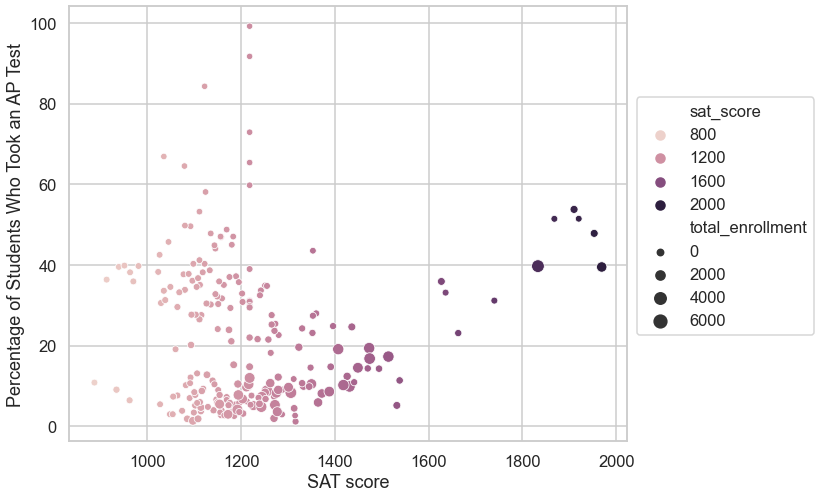

In [73]:
sns.set(style='whitegrid', context='talk')
plt.figure(figsize=(10,8))
sns.scatterplot(x='sat_score', y='ap_per', size='total_enrollment', hue='sat_score', data=combined)
plt.legend(loc='upper right', bbox_to_anchor=(1.35, .81));
plt.xlabel('SAT score')
plt.ylabel('Percentage of Students Who Took an AP Test')

There is a pretty immediately obvious weak correlation between percentage of AP test takers and average SAT scores. This could be because the larger number of AP test takers means a larger number of students who are comfortable taking standardized academic exams. More realistically, however, it should be noted that, since the less funding a school receives, [the less likely to host AP classes they are](https://scholars.unh.edu/cgi/viewcontent.cgi?article=1234&context=carsey).

<a id='poverty'></a>
# The Inequity of Poverty
The strongest correlations so far have been these:
- Smaller schools do slightly worse overall
- Larger number of ESL students means worse scores on average
- Black and Hispanic populaces typically suffer from worse scores, but the schools with higher black/hispanic populations and lower scores had high rates of poverty.
- A feeling of safety has a somewhat positive correlation with SAT scores
- Higher number of AP test takers means higher SAT scores.

Most of these, with the exception of safety (where the average student safety was relatively unimpacted by surrounding poverty levels), are directly correlated to poverty issues. To take a closer look at this, we'll examine the percentage of students receiving free or reduced-cost lunches.

Text(0, 0.5, 'Percentage of Students Receiving Reduced-Cost/Free Lunch')

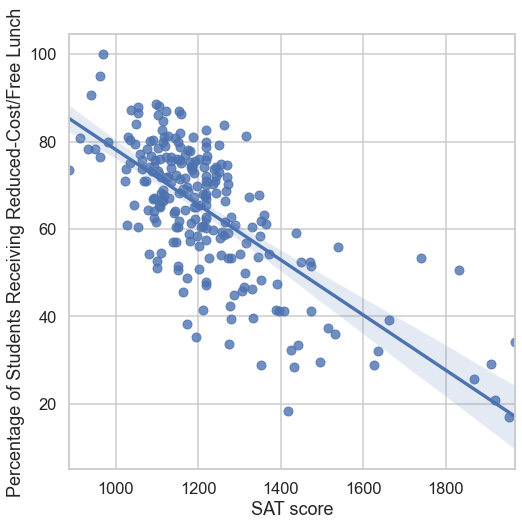

In [123]:
sns.set(style='whitegrid', context='talk')
plt.figure(figsize=(8,8))
sns.regplot(x='sat_score', y='frl_percent', data=combined)
plt.xlabel('SAT score')
plt.ylabel('Percentage of Students Receiving Reduced-Cost/Free Lunch')

Very clearly, the higher the percentage of students receiving financial aid for lunches has a clear and strong negative correlation with SAT score. The trend line slopes downward pretty steeply. 

<a id='isitover'></a>
# Conclusion
There are a variety of factors that play into a school's average SAT scores. The common factor, however, is money. The schools with lower funding tend to have fewer AP classes which means they have fewer students studying for college preparedness. Schools with higher percentages of ESL students spend more of their budget focusing on teaching English to their foreign language students. And most prominently: schools with higher percentages of students receiving lunch assistance have lower SAT scores on average. 

Money talks louder than any other factor. Students of poverty must spend larger portions of their time outside of school dedicated to survival and must overcome larger hurdles put in place by socioeconomic disadvantage. Examples of poverty-induced hurdles:
- Many high school students in poverty have to work to help with bills/rent/etc, [which can negatively impact their schoolwork, if the family is already in poverty.](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2936460/)
- Have to help with chores around the house while their parents/guardians work second or even third jobs.
- Have to rely on [reduced nutrients and cognition due to diet.](http://www.ascd.org/publications/educational-leadership/may13/vol70/num08/How-Poverty-Affects-Classroom-Engagement.aspx)
- Employed parents in poverty are least likely to get [access to the support infrastructures their children need.](https://files.eric.ed.gov/fulltext/EJ1029033.pdf)
- Poor students tend to [live in poorer regions with under-funded schools](https://www.irp.wisc.edu/publications/focus/pdfs/foc332e.pdf)
- Under-funded schools [tend to lack the funding for advanced classes](https://www.gao.gov/products/GAO-19-8) which lead to lower levels of college preparedness.

<a id='ack'></a>
# Acknowledgements 
This project is a guided project done with the guidance from Dataquest. The project was done to allow students get a better understanding of concepts of Data Cleaning.

Some stylistic and graph components were inspired by previously completed projects by fellow Dataquest students. 